# Language Classification with Naive Bayes in Python

## Project Outline
[**Introduction**](#intro)

[**Task 1**](#task1): Exploratory Data Analysis + Visualization

[**Task 2**](#task2): Data Cleaning and Preprocessing

[**Task 3**](#task3): Naive Bayes Model Introduction and Training

[**Task 4**](#task4): Highlighting Problems with Basic Model and Simple Fixes

[**Task 5**](#task5): Advanced Approach to Further Improve Performance

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import string
from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl
from helper_code import *

# Sample data

## [Slovak Wikipedia Entry](https://sk.wikipedia.org/wiki/Jazveč%C3%ADk)
Mnohí ľudia, ktorí vidia na ulici jazvečíka s podlhovastým telom vôbec nevedia o tom, že tento malý štvornohý a veľmi obľúbený spoločník je pri dobrom výcviku obratným, vynikajúcim a spoľahlivým poľovným psom. Ako poľovný pes je mnohostranne využiteľný, okrem iného ako durič na brlohárenie. Králičí jazvečík sa dokáže obratne pohybovať v králičej nore. S inými psami a deťmi si nie vždy rozumie.

## [Czech Wikipedia Entry](https://cs.wikipedia.org/wiki/Jezevč%C3%ADk)
Úplně první zmínky o psech podobných dnešním jezevčíkům nacházíme až ve Starém Egyptě, kde jsou vyobrazeni na soškách a rytinách krátkonozí psi s dlouhým hřbetem a krátkou srstí. Jednalo se ale o neustálený typ bez ustáleného jména. Další zmínky o jezevčících nacházíme až ve 14 - 15. století. Jedná se o psa, který se nejvíce podobá dnešnímu typu hladkosrstého standardního jezevčíka.


## [English Wikipedia Entry](https://en.wikipedia.org/wiki/Dachshund)
While classified in the hound group or scent hound group in the United States and Great Britain, the breed has its own group in the countries which belong to the Fédération Cynologique Internationale (World Canine Federation). Many dachshunds, especially the wire-haired subtype, may exhibit behavior and appearance that are similar to that of the terrier group of dogs.

<a id='task1'></a>
# Task 1: Data Exploration and Visualization

In [3]:
def open_file(filename):
    with open(filename, 'r',encoding="utf8") as f:
        data = f.readlines()
    return data

In [4]:
data_raw = dict()
data_raw['sk'] = open_file('Data/Sentences/train_sentences.sk')
data_raw['cs'] = open_file('Data/Sentences/train_sentences.cs')
data_raw['en'] = open_file('Data/Sentences/train_sentences.en')

In [5]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        word_list = ' '.join(sentences).split()
        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        sample_extract = ''.join(sentences[0].split(' ')[:7])
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [6]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 PándeGrandesPascualjasnevysvetlil,aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme,žejejímcílemješetřitpenězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 Icanunderstandyourapproachalittle...



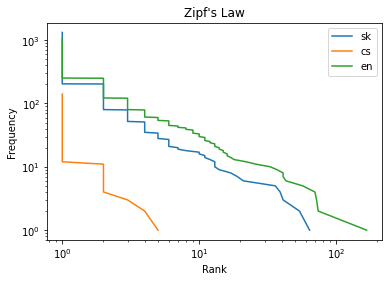

In [7]:
do_law_of_zipf(data_raw)

<a id='task2'></a>
# Task 2: Data Cleaning and Preprocessing

In [8]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
        
    preprocessed_text = text.lower().replace('-', ' ')
    
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    # the below one translates the text into based on codes in translation table
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text

In [9]:
punctuation_without_hyphen = ''.join([x for x in string.punctuation if x != '-'])
translation_table = str.maketrans('\n-', '  ', punctuation_without_hyphen+string.digits)
"""make_trans-> makes trans table----it is a dictionary k:v-> k-old values,v-new val i.e old conver to v (k->v)
1->source,2->dest
1 is converted to 2
3rd parameter is if the value is in this parameter it is converted to none"""
print(translation_table,punctuation_without_hyphen)
print(string.digits)
string.punctuation

{10: 32, 45: 32, 33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: None, 46: None, 47: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 91: None, 92: None, 93: None, 94: None, 95: None, 96: None, 123: None, 124: None, 125: None, 126: None, 48: None, 49: None, 50: None, 51: None, 52: None, 53: None, 54: None, 55: None, 56: None, 57: None} !"#$%&'()*+,./:;<=>?@[\]^_`{|}~
0123456789


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [11]:
print('raw')
show_statistics(data_raw)
print('\n\n')
print('Preprocessed')
show_statistics(data_preprocessed)

raw
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 PándeGrandesPascualjasnevysvetlil,aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme,žejejímcílemješetřitpenězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 Icanunderstandyourapproachalittle...




Preprocessed
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1996
Number of unique words	:	 1207
Sample extract		:	 pándegrandespascualjasnevysvetlilaká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 155
Number of unique words	:	 133
Sample extract		:	 upozorňujemežejejímcílemješetřitpenězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	

<a id='task3'></a>
# Task 3: The Naive Bayes Model

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Ari` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {en}) \times P(\text {en})}{P(\text {my name is Ari})}
\end{equation}

## Vectorizing Training Data

|Sentence   	||   my   	| is 	| I 	| love 	| name 	| it 	| Ari 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| my name is Ari  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

In [12]:
sentences_train, y_train = [], []

for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)


In [13]:
#it converts the data as in above 'vectorizing traing data'
vectorizer = CountVectorizer()

In [14]:
X_train = vectorizer.fit_transform(sentences_train)

In [15]:
X_train

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

## Initializing Model Parameters and Training

In [16]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB()

## Vectorizing Validation Data and Evaluating Model

In [17]:
data_val = dict()
data_val['sk'] = open_file('Data/Sentences/val_sentences.sk')
data_val['cs'] = open_file('Data/Sentences/val_sentences.cs')
data_val['en'] = open_file('Data/Sentences/val_sentences.en')

data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [18]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [19]:
X_val = vectorizer.transform(sentences_val)

In [20]:
predictions = naive_classifier.predict(X_val)

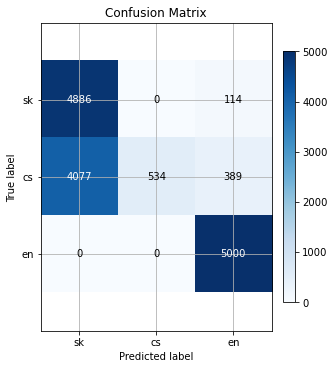

In [21]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [22]:
f1_score(y_val, predictions, average='weighted')

0.6149824401040264

<a id='task4'></a>
# Task 4: Simple Adjustments and Highlighting Model Shortcomings

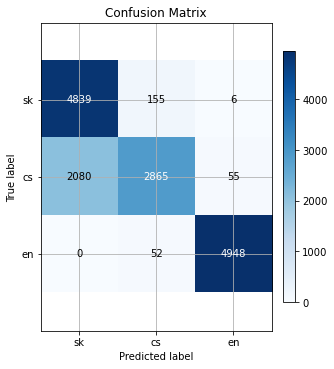

In [23]:
#alpha val is for probability of word not belonging to a lang(prob=0)
naive_classifier = MultinomialNB(alpha=0.0001, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [24]:
f1_score(y_val, predictions, average='weighted')

0.8368507601649364

<a id='task5'></a>
# Task 5: Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

In [25]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [26]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [27]:
vocab = get_vocab(sentences_train)

In [28]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [29]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [30]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [31]:
pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [32]:
def split_into_subwords(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [33]:
split_into_subwords('this is ari here')

'is th is ar re'

In [34]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k, v in data_preprocessed.items()}

In [35]:
show_statistics(data_preprocessed_subwords)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 3431
Number of unique words	:	 75
Sample extract		:	 deandealasneas...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 239
Number of unique words	:	 59
Sample extract		:	 pojemeoržejele...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 3863
Number of unique words	:	 75
Sample extract		:	 anstanerouroch...



In [36]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [ ]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

In [ ]:
naive_classifier = MultinomialNB(fit_prior=False)
naive_classifier.fit(X_train, y_train)

In [ ]:
predictions = naive_classifier.predict(X_val)

In [ ]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [ ]:
f1_score(y_val, predictions, average='weighted')

# Saving naive classifier model and vectorizer model

In [ ]:
joblib.dump(naive_classifier,'Data/Models/final_model.pkl')

In [1]:
joblib.dump(vectorizer,'Data/Vectorizers/final_model.pkl')

NameError: name 'joblib' is not defined